Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.read_csv('crude.csv')

Slicing data of last 5 years

In [3]:
# prompt: Using dataframe df: make date column the index

df1 = df.set_index('Date')
df1 = df1.loc['2017-01-01':'2022-06-16']

In [4]:
df1.head()

,OpenCrude,HighCrude,LowCrude,CloseCrude,VolumeCrude
Date,,,,,
2017-01-03,54.20,55.24,52.11,55.64,727793
2017-01-04,52.49,53.43,52.15,56.79,512641
2017-01-05,53.39,54.12,52.79,57.36,517362
2017-01-06,53.73,54.32,53.32,57.50,528333
2017-01-09,53.75,53.83,51.76,56.41,564893


In [5]:
df1.shape

(1374, 5)

In [6]:
# Check for null values in your DataFrame
print(df1.isnull().sum())


OpenCrude      0
HighCrude      0
LowCrude       0
CloseCrude     0
VolumeCrude    0
dtype: int64


In [7]:
# Drop rows with null values
df1.dropna(inplace=True)


Plotting the trend of closing price

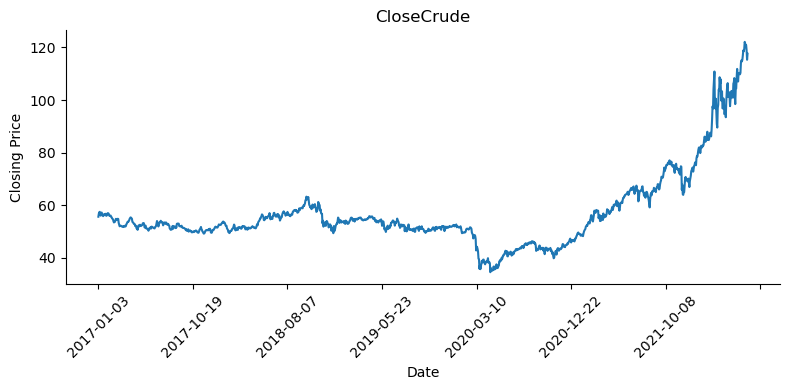

In [8]:
# @title CloseCrude

import matplotlib.pyplot as plt

# Plot the 'CloseCrude' column
df1['CloseCrude'].plot(kind='line', figsize=(8, 4), title='CloseCrude')

# Remove the top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Rotate x-axis date labels
plt.xticks(rotation=45)

# Add labels and title

plt.ylabel('Closing Price')



# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()


Feature scaling

In [11]:
# Prepare data for LSTM
data = df1['CloseCrude'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Preparing data for lstm

In [12]:
# Function to create dataset for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time step (number of previous days to use for prediction)
time_step = 100

# Create dataset for LSTM
X, y = create_dataset(scaled_data, time_step)

In [17]:
# Reshape X to be in the form [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [19]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = y[:train_size], y[train_size:]

Defining model

In [16]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Train the model
model.fit(X_train, Y_train, epochs=3, batch_size=1)

Epoch 1/3
1018/1018 [==============================] - 22s 20ms/step - loss: 6.1033e-04
Epoch 2/3
1018/1018 [==============================] - 20s 19ms/step - loss: 2.5109e-04
Epoch 3/3
1018/1018 [==============================] - 20s 19ms/step - loss: 1.8565e-04


In [22]:
# Predicting on test data
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)

8/8 [==============================] - 1s 15ms/step


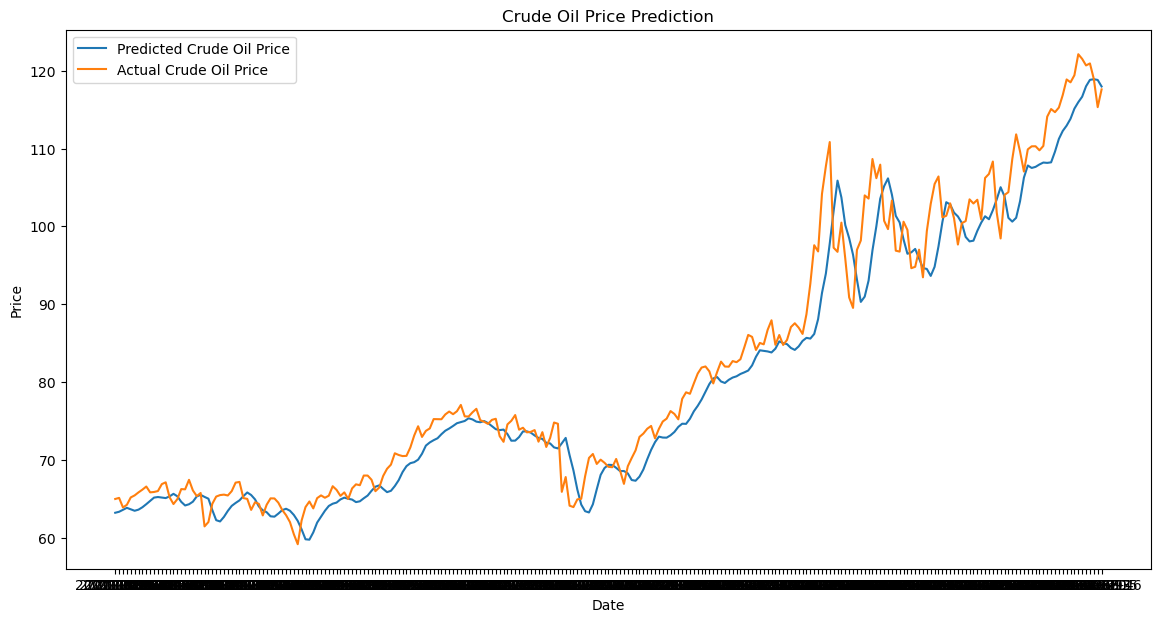

In [27]:
# Optional: Visualize the results
plt.figure(figsize=(14, 7))
dates = df1.index[train_size + time_step + 1:]  # Assuming 'Date' is the index
plt.plot(dates, predicted_price, label='Predicted Crude Oil Price')
plt.plot(dates, df1['CloseCrude'].values[train_size + time_step + 1:], label='Actual Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Crude Oil Price Prediction')
plt.legend()
plt.show()


In [42]:

# Create a DataFrame slice for the test data range
valid = df1[['CloseCrude']].iloc[train_size + time_step + 1:].copy()

# Add the predicted prices as a new column 'predicted_price' in 'valid'
valid['predicted_price'] = predicted_price.flatten()

# Display the head of the updated 'valid' DataFrame
print(valid.head())


            CloseCrude  predicted_price
Date                                   
2021-06-15       64.99        63.220200
2021-06-16       65.13        63.347694
2021-06-17       63.90        63.594505
2021-06-18       64.24        63.852646
2021-06-21       65.19        63.667019


In [43]:
model_path = 'crude_oil_lstm_model.h5'

# Save the model
model.save(model_path)